Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 5, 64)          │         3,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,259 (32.26 KB)

 Trainable params: 8,259 (32.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.3373 - loss: 1.1596 - val_accuracy: 0.5333 - val_loss: 0.9653
Epoch 2/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7327 - loss: 0.8163 - val_accuracy: 0.5333 - val_loss: 0.8526
Epoch 3/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7956 - loss: 0.6871 - val_accuracy: 0.9333 - val_loss: 0.6320
Epoch 4/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8291 - loss: 0.6130 - val_accuracy: 1.0000 - val_loss: 0.4990
Epoch 5/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9818 - loss: 0.5022 - val_accuracy: 1.0000 - val_loss: 0.3956
Epoch 6/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9575 - loss: 0.4155 - val_accuracy: 1.0000 - val_loss: 0.3081
Epoch 7/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9854 - loss: 0.3340 - val_accuracy: 1.0000 - val_loss: 0.2598
Epoch 8/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9855 - loss: 0.3301 - val_accuracy: 1.0000 - val_lo

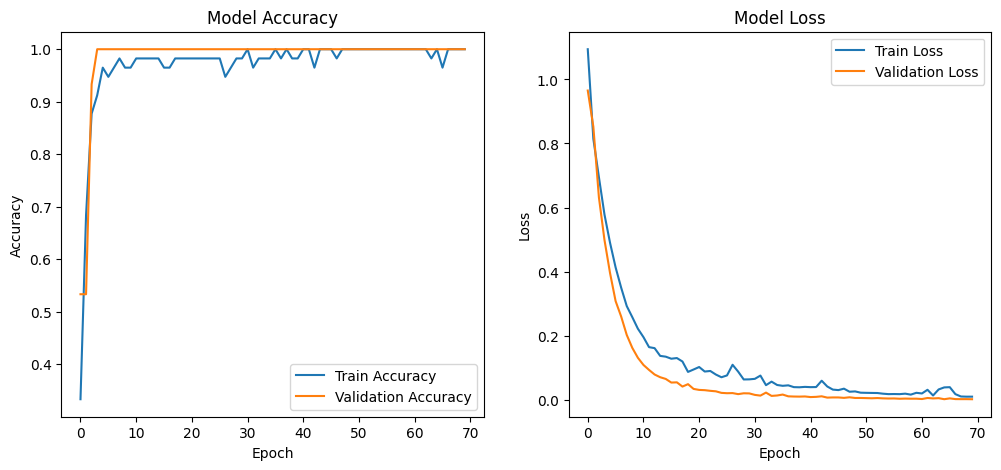

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.initializers import Constant
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# CustomRowPooling1D
class CustomRowPooling1D(layers.Layer):
    def __init__(self, pool_size=2, stride=None, **kwargs):
        super(CustomRowPooling1D, self).__init__(**kwargs)
        self.pool_size = pool_size
        self.stride = stride if stride else pool_size

    def call(self, inputs):
        batch_size, time_steps, features = inputs.shape
        outputs = []
        for i in range(0, time_steps - self.pool_size + 1, self.stride):
            window = inputs[:, i:i + self.pool_size, :]
            if window.shape[1] < 3:
                continue
            max_values = tf.reduce_max(
                [
                    window[:, -1, :] / (window[:, -2, :] + 1e-8),
                    window[:, -2, :] / (window[:, -3, :] + 1e-8)
                ],
                axis=0
            )
            outputs.append(max_values)
        if len(outputs) == 0:
            return inputs
        return tf.stack(outputs, axis=1)

    def compute_output_shape(self, input_shape):
        time_steps = input_shape[1]
        output_time_steps = max(1, (time_steps - self.pool_size + 1) // self.stride)
        return (input_shape[0], output_time_steps, input_shape[2])

    def get_config(self):
        config = super().get_config()
        config.update({"pool_size": self.pool_size, "stride": self.stride})
        return config

# Dataset
num_classes = 3
samples_per_class = 30
matrix_size = (5, 20)

dataset = []
labels = []

for class_idx in range(num_classes):
    class_data = np.zeros((samples_per_class, matrix_size[0], matrix_size[1]))

    for sample_idx in range(samples_per_class):
        matrix = np.eye(matrix_size[0], matrix_size[1])

        for row in range(matrix_size[0]):
            matrix[row, 0] = np.random.rand()*10

            for col in range(1, matrix_size[1]):
                if class_idx == 0:
                    factor = 1 + np.random.rand()
                elif class_idx == 1:
                    factor = 3 + np.random.rand()
                elif class_idx == 2:
                    factor = 5 + np.random.rand()

                matrix[row, col] = matrix[row, col-1] * factor
                if matrix[row, col] > 4000:
                    matrix[row, col] = 4000

        class_data[sample_idx, :, :] = matrix

    dataset.append(class_data)
    labels += [class_idx] * samples_per_class

dataset = np.array(dataset).reshape(-1, matrix_size[0], matrix_size[1])
labels = np.array(labels)

# normalization

dataset = dataset / (np.max(dataset) if np.max(dataset) > 0 else 1)

X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, random_state=42)

y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

# Neural Network

model = models.Sequential([
    layers.Input(shape=(matrix_size[0], matrix_size[1])),


   ## Typical CNN

    layers.Conv1D(
        filters=64,
        kernel_size=3,
        activation='relu',
        padding='same'
    ),

    layers.MaxPooling1D(pool_size=3),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=70,
    batch_size=6,
    verbose=1
)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()
